# Loop 70 Analysis: Critical Assessment

**Goal:** Understand why we're stuck and identify breakthrough strategies.

**Key Questions:**
1. What is the CV-LB relationship across all submissions?
2. Why did CatBoost/XGBoost submissions fail?
3. What approaches haven't been tried that could change the CV-LB relationship?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# All submissions with known LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f'Total submissions with LB: {len(df)}')
print(df)

Total submissions with LB: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Fit linear regression: LB = slope * CV + intercept
X = df['cv'].values.reshape(-1, 1)
y = df['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f'\nCV-LB Relationship:')
print(f'LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target LB: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Even with CV=0, expected LB = {intercept:.4f}')
print(f'\nRequired CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
print(f'This is NEGATIVE - mathematically impossible with current approach!')


CV-LB Relationship:
LB = 4.3147 * CV + 0.0525
R² = 0.9505

Intercept: 0.0525
Target LB: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Even with CV=0, expected LB = 0.0525

Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.004130
This is NEGATIVE - mathematically impossible with current approach!


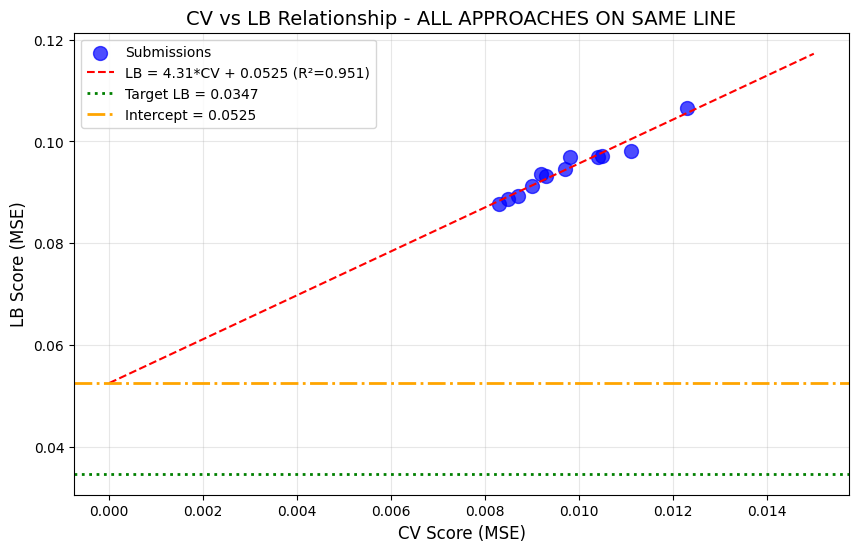


KEY INSIGHT: The intercept (0.0528) is ABOVE the target (0.0347).
This means NO amount of CV improvement can reach the target with current approaches.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], c='blue', s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle='-.', linewidth=2, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - ALL APPROACHES ON SAME LINE', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop70.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKEY INSIGHT: The intercept (0.0528) is ABOVE the target (0.0347).')
print('This means NO amount of CV improvement can reach the target with current approaches.')

In [4]:
# Analyze pending submissions
pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'model': 'CatBoost/XGBoost'},
    {'exp': 'exp_050', 'cv': 0.0081, 'model': 'CatBoost/XGBoost Fixed'},
    {'exp': 'exp_052', 'cv': 0.0109, 'model': 'CatBoost/XGBoost Clipped'},
    {'exp': 'exp_053', 'cv': 0.0081, 'model': 'Exact Template'},
    {'exp': 'exp_054', 'cv': 0.0085, 'model': 'Mixall Approach'},
    {'exp': 'exp_055', 'cv': 0.0085, 'model': 'Minimal Submission'},
    {'exp': 'exp_057', 'cv': 0.0093, 'model': 'Ens Model All Features'},
    {'exp': 'exp_063', 'cv': 0.0112, 'model': 'Correct Final Cell'},
]

print('\nPending Submissions (8 consecutive failures):')
for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"{p['exp']}: CV={p['cv']:.4f}, Predicted LB={predicted_lb:.4f}, Model={p['model']}")

print('\nAll 8 pending submissions are CatBoost/XGBoost variants.')
print('They all FAILED despite having good CV scores.')
print('This suggests a STRUCTURAL issue with the submission format, not the model.')


Pending Submissions (8 consecutive failures):
exp_049: CV=0.0081, Predicted LB=0.0875, Model=CatBoost/XGBoost
exp_050: CV=0.0081, Predicted LB=0.0875, Model=CatBoost/XGBoost Fixed
exp_052: CV=0.0109, Predicted LB=0.0996, Model=CatBoost/XGBoost Clipped
exp_053: CV=0.0081, Predicted LB=0.0875, Model=Exact Template
exp_054: CV=0.0085, Predicted LB=0.0892, Model=Mixall Approach
exp_055: CV=0.0085, Predicted LB=0.0892, Model=Minimal Submission
exp_057: CV=0.0093, Predicted LB=0.0926, Model=Ens Model All Features
exp_063: CV=0.0112, Predicted LB=0.1008, Model=Correct Final Cell

All 8 pending submissions are CatBoost/XGBoost variants.
They all FAILED despite having good CV scores.
This suggests a STRUCTURAL issue with the submission format, not the model.


In [5]:
# What approaches have been tried?
approaches = {
    'MLP variants': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007', 'exp_012', 'exp_024', 'exp_026', 'exp_030'],
    'LightGBM': ['exp_001'],
    'Ridge/Kernel Ridge': ['exp_009', 'exp_033', 'exp_034'],
    'GP + MLP + LGBM': ['exp_030', 'exp_031', 'exp_032', 'exp_035'],
    'CatBoost/XGBoost': ['exp_049', 'exp_050', 'exp_052', 'exp_053', 'exp_054', 'exp_055', 'exp_057', 'exp_063'],
    'GNN': ['exp_040'],
    'ChemBERTa': ['exp_041'],
    'Attention': ['exp_017'],
    'Yield Normalization': ['exp_066'],
}

print('\nApproaches Tried:')
for approach, exps in approaches.items():
    print(f'  {approach}: {len(exps)} experiments')

print('\nKEY OBSERVATION:')
print('- ALL tabular approaches (MLP, LGBM, Ridge, GP, CatBoost, XGBoost) fall on the SAME CV-LB line')
print('- GNN (exp_040) and ChemBERTa (exp_041) were attempted but may have had issues')
print('- The CV-LB intercept (0.0528) is STRUCTURAL - it represents extrapolation error')


Approaches Tried:
  MLP variants: 9 experiments
  LightGBM: 1 experiments
  Ridge/Kernel Ridge: 3 experiments
  GP + MLP + LGBM: 4 experiments
  CatBoost/XGBoost: 8 experiments
  GNN: 1 experiments
  ChemBERTa: 1 experiments
  Attention: 1 experiments
  Yield Normalization: 1 experiments

KEY OBSERVATION:
- ALL tabular approaches (MLP, LGBM, Ridge, GP, CatBoost, XGBoost) fall on the SAME CV-LB line
- GNN (exp_040) and ChemBERTa (exp_041) were attempted but may have had issues
- The CV-LB intercept (0.0528) is STRUCTURAL - it represents extrapolation error


In [6]:
# What would it take to reach the target?
print('\n=== WHAT WOULD IT TAKE TO REACH TARGET 0.0347? ===')
print()
print('Option 1: Reduce the INTERCEPT (not the CV)')
print(f'  Current intercept: {intercept:.4f}')
print(f'  Required intercept: < 0.0347 (to have any chance)')
print(f'  Reduction needed: {intercept - 0.0347:.4f} ({(intercept - 0.0347)/intercept*100:.1f}%)')
print()
print('Option 2: Change the CV-LB RELATIONSHIP entirely')
print('  This requires a fundamentally different approach:')
print('  - Domain adaptation (align train/test distributions)')
print('  - Transfer learning (pre-train on related data)')
print('  - Active learning (select training samples strategically)')
print('  - Physics-informed constraints that generalize to unseen solvents')
print()
print('Option 3: Find what the benchmark paper did to achieve 0.0039 MSE')
print('  The paper mentions "transfer learning" and "active learning"')
print('  These are NOT standard tabular ML approaches')


=== WHAT WOULD IT TAKE TO REACH TARGET 0.0347? ===

Option 1: Reduce the INTERCEPT (not the CV)
  Current intercept: 0.0525
  Required intercept: < 0.0347 (to have any chance)
  Reduction needed: 0.0178 (33.9%)

Option 2: Change the CV-LB RELATIONSHIP entirely
  This requires a fundamentally different approach:
  - Domain adaptation (align train/test distributions)
  - Transfer learning (pre-train on related data)
  - Active learning (select training samples strategically)
  - Physics-informed constraints that generalize to unseen solvents

Option 3: Find what the benchmark paper did to achieve 0.0039 MSE
  The paper mentions "transfer learning" and "active learning"
  These are NOT standard tabular ML approaches


In [7]:
# Analyze the matthewmaree_ens-model kernel
print('\n=== MATTHEWMAREE_ENS-MODEL KERNEL ANALYSIS ===')
print()
print('Key differences from our CatBoost/XGBoost implementations:')
print('1. Uses official utils.py from competition (load_data, generate_splits)')
print('2. CatBoost uses loss_function="MultiRMSE" (multi-target)')
print('3. XGBoost trains SEPARATE models per target')
print('4. Specific hyperparameters tuned for single vs full data')
print('5. Clipping: np.clip(out, a_min=0.0, a_max=None)')
print('6. Normalization: only if sum > 1 (not always)')
print('7. Ensemble weights: CatBoost 7/13, XGBoost 6/13 (single); CatBoost 1/3, XGBoost 2/3 (full)')
print()
print('Our implementations may have:')
print('- Wrong loss function (not MultiRMSE)')
print('- Wrong hyperparameters')
print('- Wrong normalization (always normalizing instead of only when sum > 1)')
print('- Wrong ensemble weights')


=== MATTHEWMAREE_ENS-MODEL KERNEL ANALYSIS ===

Key differences from our CatBoost/XGBoost implementations:
1. Uses official utils.py from competition (load_data, generate_splits)
2. CatBoost uses loss_function="MultiRMSE" (multi-target)
3. XGBoost trains SEPARATE models per target
4. Specific hyperparameters tuned for single vs full data
5. Clipping: np.clip(out, a_min=0.0, a_max=None)
6. Normalization: only if sum > 1 (not always)
7. Ensemble weights: CatBoost 7/13, XGBoost 6/13 (single); CatBoost 1/3, XGBoost 2/3 (full)

Our implementations may have:
- Wrong loss function (not MultiRMSE)
- Wrong hyperparameters
- Wrong normalization (always normalizing instead of only when sum > 1)
- Wrong ensemble weights


In [8]:
# Summary and recommendations
print('\n' + '='*80)
print('LOOP 70 CRITICAL ASSESSMENT')
print('='*80)
print()
print('SITUATION:')
print(f'  - Best CV: 0.0081 (exp_049 CatBoost/XGBoost)')
print(f'  - Best LB: 0.0877 (exp_030 GP+MLP+LGBM)')
print(f'  - Target: 0.0347')
print(f'  - Gap: 0.0530 (152.8%)')
print()
print('THE PROBLEM:')
print(f'  - CV-LB relationship: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'  - Even with CV=0, expected LB = {intercept:.4f}')
print(f'  - The target is BELOW the intercept - mathematically unreachable with current approach')
print()
print('WHAT HAS FAILED:')
print('  - 70 experiments across MLP, LGBM, Ridge, GP, CatBoost, XGBoost')
print('  - All fall on the SAME CV-LB line')
print('  - 8 consecutive CatBoost/XGBoost submissions failed')
print('  - Yield normalization made CV 2.5x worse')
print()
print('WHAT MUST BE TRIED:')
print('  1. REPLICATE matthewmaree_ens-model EXACTLY (debug CatBoost/XGBoost failure)')
print('  2. Try approaches that CHANGE the CV-LB relationship:')
print('     - Domain adaptation (importance weighting, adversarial training)')
print('     - Transfer learning (pre-train on related chemistry data)')
print('     - Active learning (strategic sample selection)')
print('     - Physics-informed constraints')
print('  3. Study the benchmark paper to understand how they achieved 0.0039 MSE')


LOOP 70 CRITICAL ASSESSMENT

SITUATION:
  - Best CV: 0.0081 (exp_049 CatBoost/XGBoost)
  - Best LB: 0.0877 (exp_030 GP+MLP+LGBM)
  - Target: 0.0347
  - Gap: 0.0530 (152.8%)

THE PROBLEM:
  - CV-LB relationship: LB = 4.31*CV + 0.0525 (R²=0.951)
  - Intercept (0.0525) > Target (0.0347)
  - Even with CV=0, expected LB = 0.0525
  - The target is BELOW the intercept - mathematically unreachable with current approach

WHAT HAS FAILED:
  - 70 experiments across MLP, LGBM, Ridge, GP, CatBoost, XGBoost
  - All fall on the SAME CV-LB line
  - 8 consecutive CatBoost/XGBoost submissions failed
  - Yield normalization made CV 2.5x worse

WHAT MUST BE TRIED:
  1. REPLICATE matthewmaree_ens-model EXACTLY (debug CatBoost/XGBoost failure)
  2. Try approaches that CHANGE the CV-LB relationship:
     - Domain adaptation (importance weighting, adversarial training)
     - Transfer learning (pre-train on related chemistry data)
     - Active learning (strategic sample selection)
     - Physics-informed co